# T5

In [1]:
import numpy as np
import scipy.stats as sps
from scipy.special import erfinv

import matplotlib.pyplot as plt
from matplotlib import ticker

## Генерируем выборку для распределения

Воспользуемся встроенной функцией в пакете `scipy.stats`. Заметим, что она имеет следующий закон распределения: $$p(x, \theta ^* ) = \frac{\theta ^*}{x^{\theta ^* + 1}}$$

Получается, что у в нашем случае $\theta ^* = \theta - 1$. Запомним это и будем брать всегда $\theta - 1$.

Возьмем $\theta = 10$, тогда $\theta ^* = 9$

In [2]:
sample = sps.pareto.rvs(9, size=100)
n = len(sample)
beta = 0.95

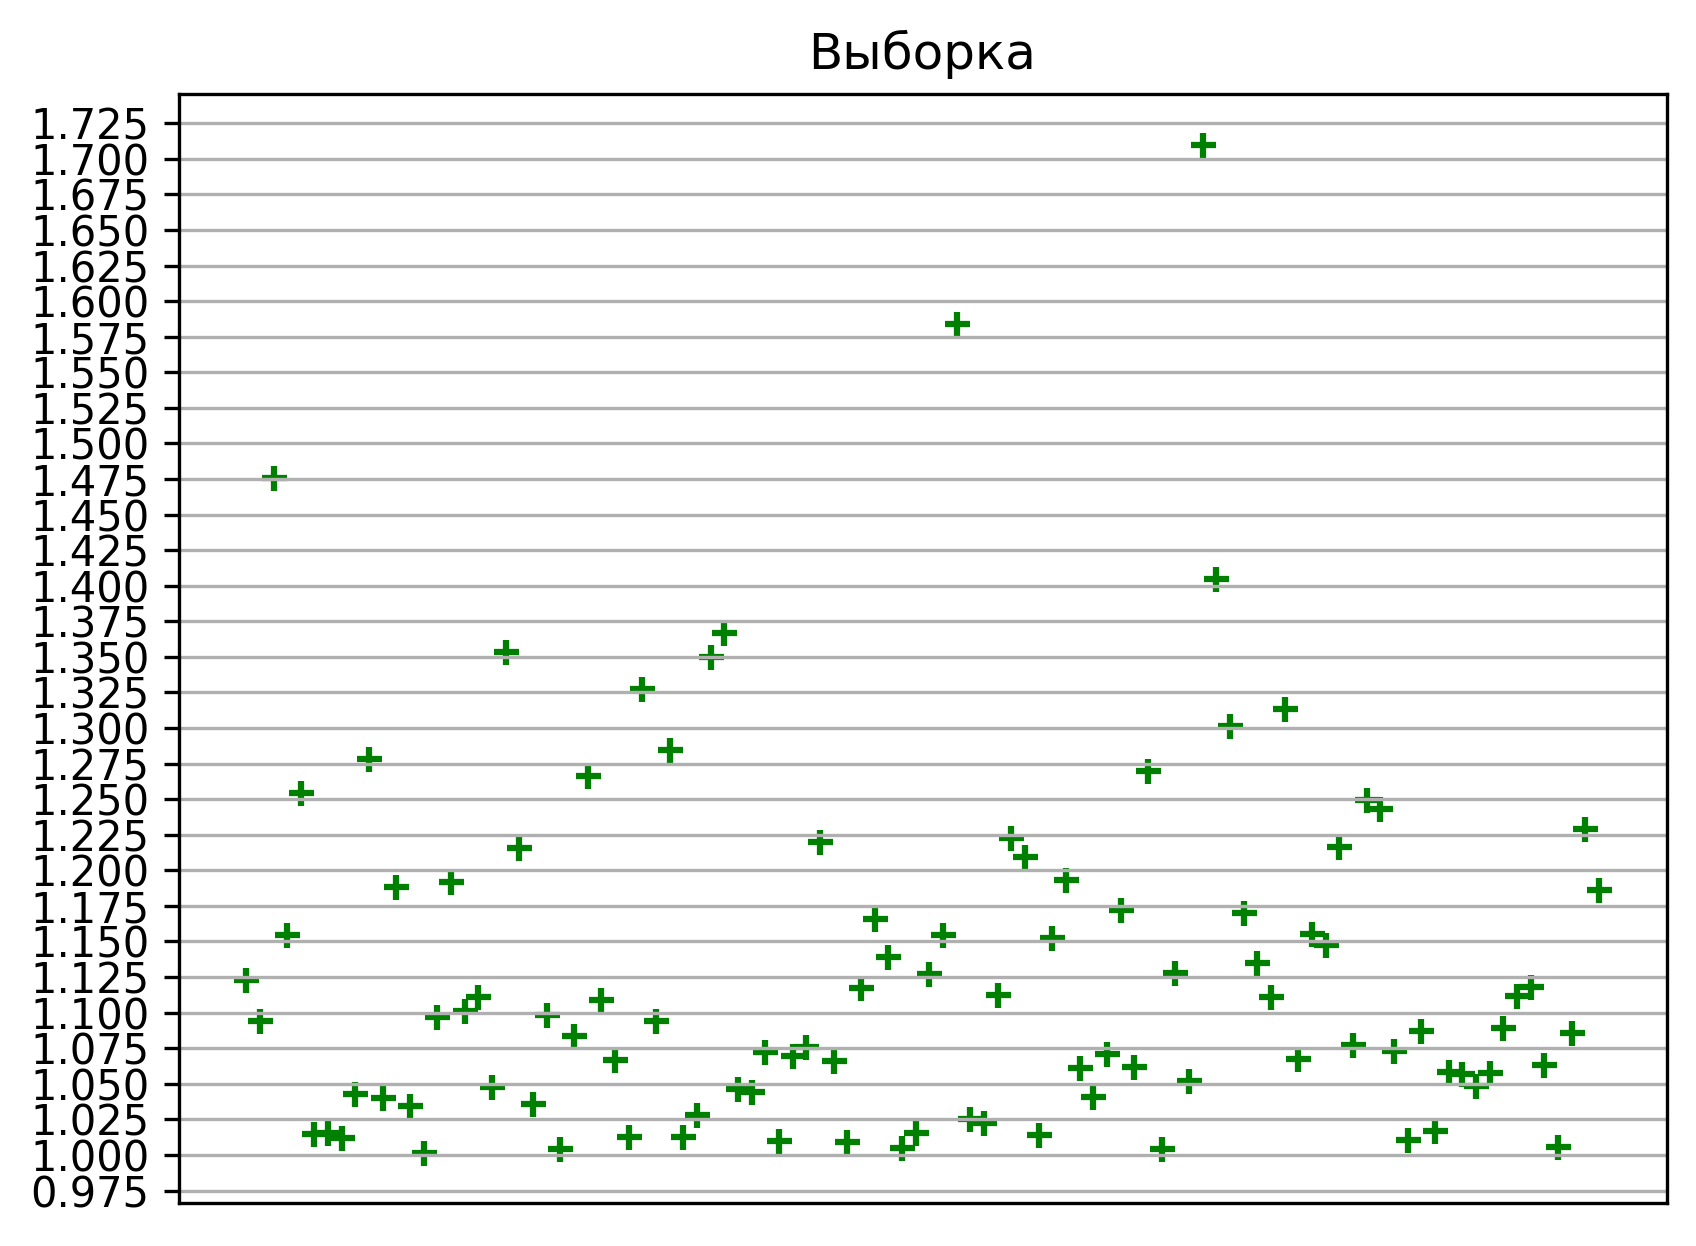

In [3]:
X = np.arange(1, 101)
Y = sample

fig, ax = plt.subplots(dpi=300)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.025))
ax.set_xticks([])

ax.grid(True)

ax.scatter(X, Y, marker='+', color='green')
ax.set_title("Выборка")

plt.show()

## Строим доверительный интервал для медианы + асимптотические доверительные интервалы по ОММ и ОМП

### Доверительный интервал для медианы 💀

In [4]:
theta_wave = n / sum(np.log(sample)) + 1
equal_part = np.sqrt(2) * erfinv(-beta) * 2 ** (1 / (theta_wave - 1)) * np.log(2) / (theta_wave - 1) ** 2 / np.sqrt(n)
h1 = equal_part + (2 ** (1 / (theta_wave - 1)))
h2 = -equal_part + (2 ** (1 / (theta_wave - 1)))
print(f"Доверительный интервал для медианы: ({h1}, {h2}). Длина: {h2 - h1}")

Доверительный интервал для медианы: (1.0841978807310195, 1.0884076068852468). Длина: 0.004209726154227322


### Асимптотический доверительный интервал по ОМП

In [5]:
omp_h1 = np.sqrt(2 / n) * (theta_wave - 1) * erfinv(-beta) + theta_wave
omp_h2 = -np.sqrt(2 / n) * (theta_wave - 1) * erfinv(-beta) + theta_wave
print(f"Асимптотический доверительный интервал по ОМП: ({omp_h1}, {omp_h2}). Длина: {omp_h2 - omp_h1}")

Асимптотический доверительный интервал по ОМП: (7.73221974885081, 11.014520529191788). Длина: 3.282300780340978


### Асимптотический доверительный интервал по ОММ 💀💀

In [6]:
x_mean = np.mean(sample)
x_square_mean = np.mean(sample ** 2)
omm_equal_part = np.sqrt((2 / n)) * erfinv(-beta) * (np.sqrt(x_square_mean) - x_mean ** 2) / ((x_mean - 1) ** 2)
omm_h2 = omm_equal_part + (1 / (x_mean - 1)) + 2
omm_h1 = -omm_equal_part + (1 / (x_mean - 1)) + 2
print(f"Асимптотический доверительный интервал по ОММ: ({omm_h1}, {omm_h2}). Длина: {omm_h2 - omm_h1}")

Асимптотический доверительный интервал по ОММ: (7.91826381218556, 11.09741610831571). Длина: 3.179152296130149


## Bootstrap

### Параметрический bootstrap ОМП 🌞🌞🌞

In [7]:
N = 100000
parametric_bootstrap_omp = np.array([
    sps.pareto.rvs(theta_wave - 1, size=len(sample)) for _ in range(N)
])

theta_waves = []
for parametric_sample_omp in parametric_bootstrap_omp:
    theta_waves.append(n / np.sum(np.log(parametric_sample_omp)) + 1)

theta_waves = np.sort(theta_waves)
k1 = int((1 - beta) * N / 2) - 1
k2 = int((1 + beta) * N / 2) - 1

parametric_h1 = theta_waves[k1]
parametric_h2 = theta_waves[k2]
print(f"Параметрический bootstrap ОМП: ({parametric_h1}, {parametric_h2}). Длина: {parametric_h2 - parametric_h1}")

Параметрический bootstrap ОМП: (7.94761169326927, 11.297165978291114). Длина: 3.349554285021844


### Параметрический bootstrap ОММ 🌞

Почему солнышко? Потому что он магическим образом отработал очень быстро

In [8]:
x_mean = 1 / (np.mean(sample) - 1) + 2

parametric_bootstrap_omm = np.array([
    sps.pareto.rvs(x_mean - 1, size=len(sample)) for _ in range(N)
])

theta_waves_omm = []
for parametric_sample_omm in parametric_bootstrap_omm:
    theta_waves_omm.append(1 / (np.mean(parametric_sample_omm) - 1) + 2)

theta_waves_omm = np.sort(theta_waves_omm)
k1_omm = int((1 - beta) * N / 2) - 1
k2_omm = int((1 + beta) * N / 2) - 1

parametric_h1_omm = theta_waves_omm[k1_omm]
parametric_h2_omm = theta_waves_omm[k2_omm]
print(f"Параметрический bootstrap ОМП: ({parametric_h1_omm}, {parametric_h2_omm}). Длина: {parametric_h2_omm - parametric_h1_omm}")

Параметрический bootstrap ОМП: (8.060399294162648, 11.474791585990356). Длина: 3.414392291827708


### Параметрический bootstrap для медианы

In [9]:
median = 2 ** (1 / (theta_wave - 1))
parametric_bootstrap_median = np.array([
    sps.pareto.rvs(theta_wave - 1, size=len(sample)) for _ in range(N)
])

theta_waves_median = []
for parametric_sample_median in parametric_bootstrap_median:
    wave = n / np.sum(np.log(parametric_sample_median)) + 1
    theta_waves_median.append(2 ** (1 / (wave - 1)))

theta_waves_median = np.sort(theta_waves_median)
k1_median = int((1 - beta) * N / 2) - 1
k2_median = int((1 + beta) * N / 2) - 1

parametric_h1_median = theta_waves_median[k1_median]
parametric_h2_median = theta_waves_median[k2_median]
print(f"Параметрический bootstrap медиана: ({parametric_h1_median}, {parametric_h2_median}). Длина: {parametric_h2_median - parametric_h1_median}")

Параметрический bootstrap медиана: (1.069748259396931, 1.1050587311675257). Длина: 0.035310471770594765


### Непараметрический bootstrap ОМП

In [10]:
nonparametric_bootstrap_omp = np.array([
    np.random.choice(sample, 100) for _ in range(1000)
])

theta_wave = n / np.sum(np.log(sample)) + 1
nonparam_thetas = []
for nonparam_sample in nonparametric_bootstrap_omp:
    theta_star = (n / np.sum(np.log(nonparam_sample)) + 1)
    nonparam_thetas.append(theta_star - theta_wave)

nonparam_thetas.sort()
nonparam_h1 = -nonparam_thetas[974] + theta_wave
nonparam_h2 = -nonparam_thetas[24] + theta_wave
print(f"Непараметрический bootstrap ОМП: ({nonparam_h1}, {nonparam_h2}). Длина: {nonparam_h2 - nonparam_h1}")

Непараметрический bootstrap ОМП: (7.6339265826111085, 10.59348502960987). Длина: 2.959558446998761


### Непараметрический bootstrap ОММ

In [11]:
nonparametric_bootstrap_omm = np.array([
    np.random.choice(sample, 100) for _ in range(1000)
])

x_mean = 1 / (np.mean(sample) - 1) + 2
nonparam_thetas_omm = []
for nonparam_sample in nonparametric_bootstrap_omm:
    theta_star = 1 / (np.mean(nonparam_sample) - 1) + 2
    nonparam_thetas_omm.append(theta_star - x_mean)

nonparam_thetas_omm.sort()
nonparam_h1_omm = -nonparam_thetas_omm[974] + x_mean
nonparam_h2_omm = -nonparam_thetas_omm[24] + x_mean
print(f"Непараметрический bootstrap ОММ: ({nonparam_h1_omm}, {nonparam_h2_omm}). Длина: {nonparam_h2 - nonparam_h1}")

Непараметрический bootstrap ОММ: (7.753211434395611, 10.859687604461847). Длина: 2.959558446998761


### Непараметрический bootstrap медиана

In [12]:
nonparametric_bootstrap_median = np.array([
    np.random.choice(sample, 100) for _ in range(1000)
])

median = 2 ** (1 / (theta_wave - 1))

nonparam_thetas_median = []
for nonparam_sample in nonparametric_bootstrap_median:
    nonparam_thetas_median.append(np.median(nonparam_sample) - median)

nonparam_thetas_median.sort()
nonparam_h1_median = -nonparam_thetas_median[974] + median
nonparam_h2_median = -nonparam_thetas_median[24] + median
print(f"Непараметрический bootstrap медиана: ({nonparam_h1_median}, {nonparam_h2_median}). Длина: {nonparam_h2_median - nonparam_h1_median}")

Непараметрический bootstrap медиана: (1.0548413889533492, 1.1017833267305968). Длина: 0.04694193777724753


## Сравнение

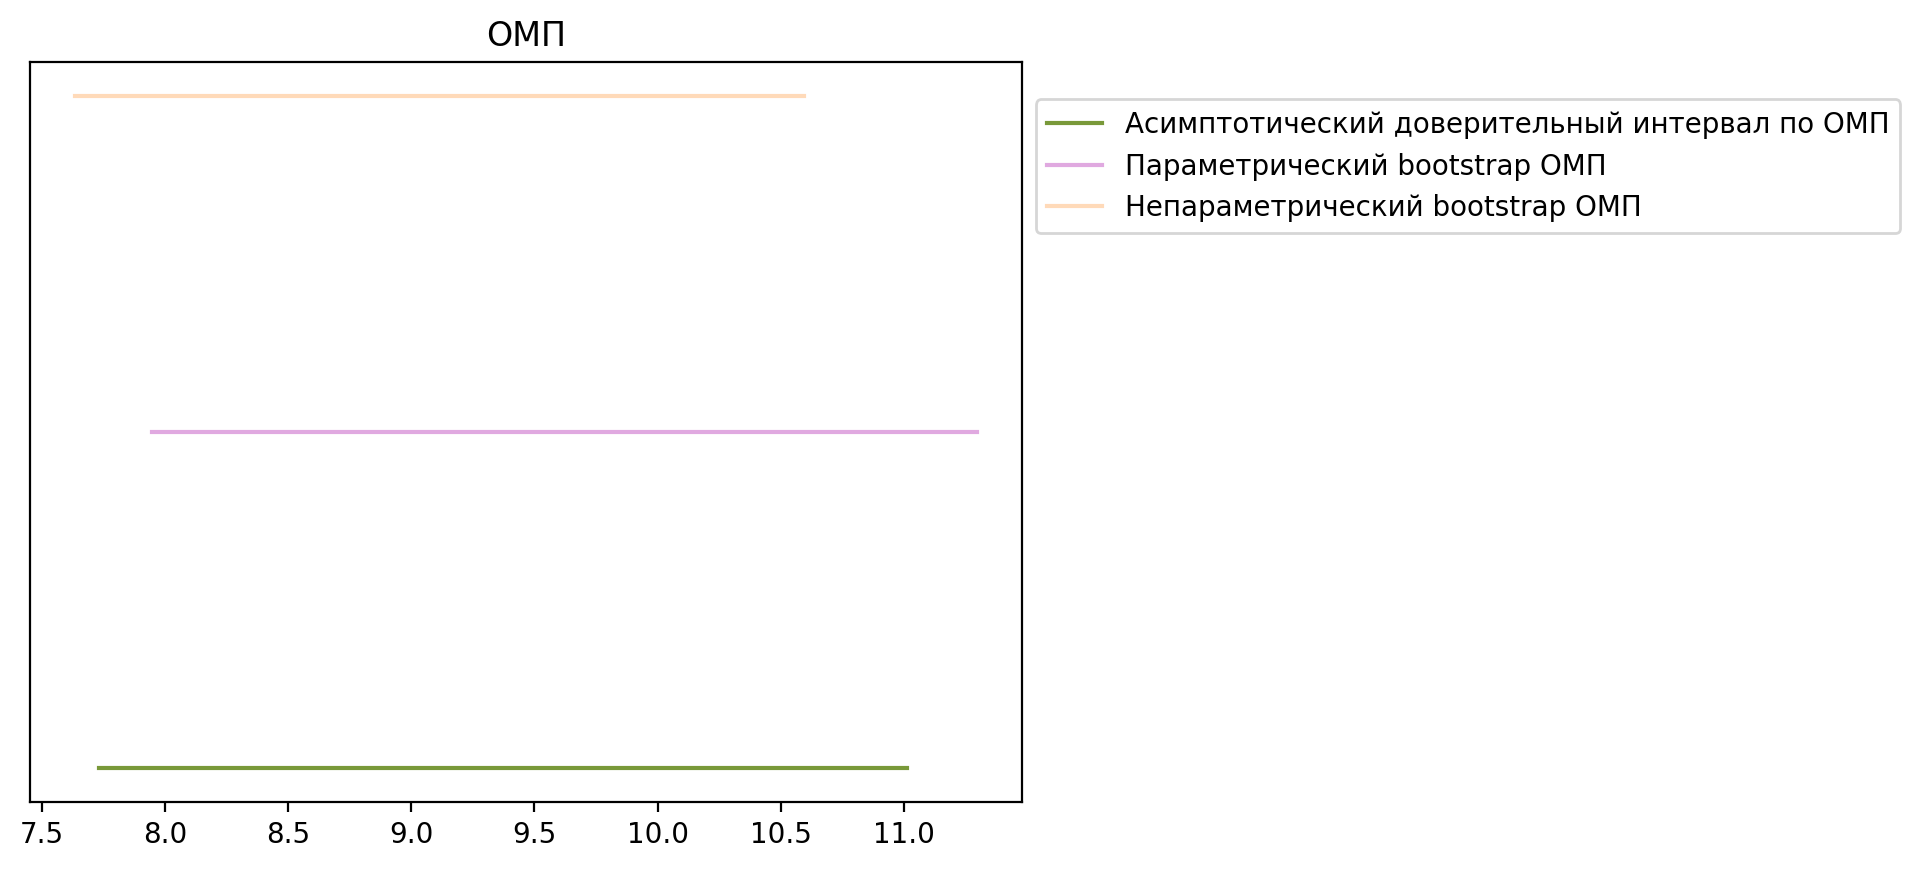

In [13]:
fig2, ax2 = plt.subplots(dpi=200)

ax2.plot([omp_h1, omp_h2], [1, 1], color='olivedrab', label='Асимптотический доверительный интервал по ОМП', alpha=0.9)
ax2.plot([parametric_h1, parametric_h2], [1.2, 1.2], color='plum',  label='Параметрический bootstrap ОМП', alpha=0.9)
ax2.plot([nonparam_h1, nonparam_h2], [1.4, 1.4], color='peachpuff', label='Непараметрический bootstrap ОМП')

ax2.set_yticks([])
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.5))

ax2.set_title("ОМП")
ax2.legend(loc='lower left', bbox_to_anchor=(1, 0.75))

plt.show()

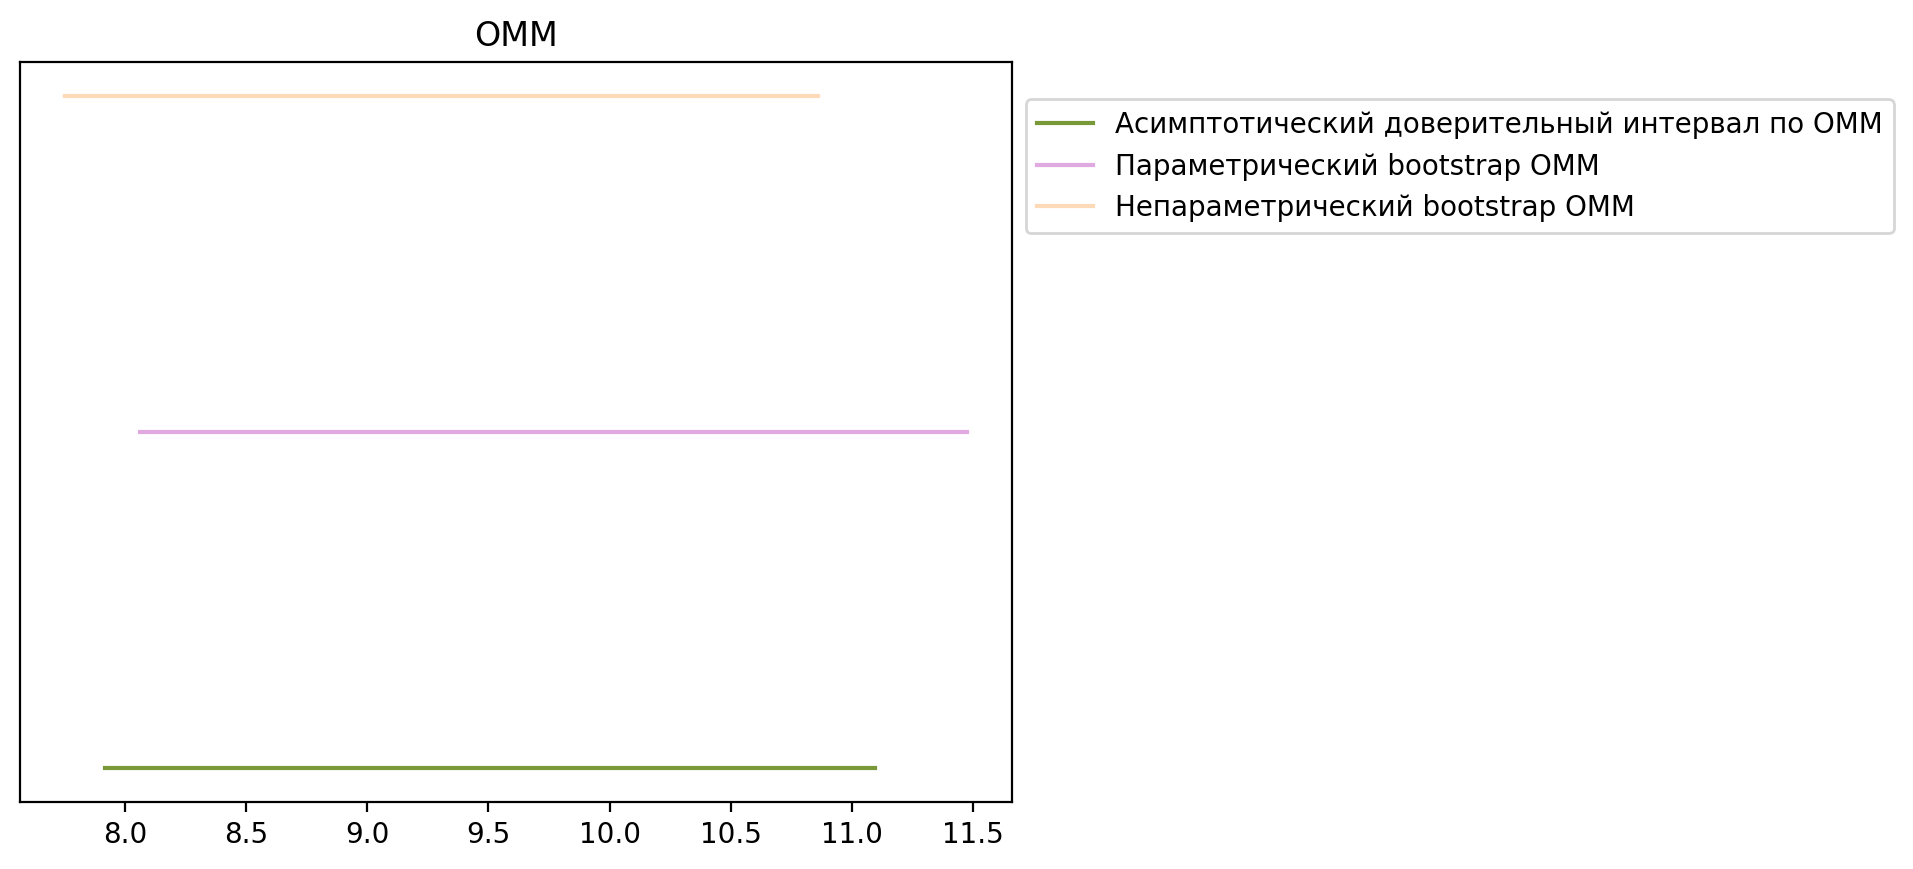

In [14]:
fig2, ax3 = plt.subplots(dpi=200)

ax3.plot([omm_h1, omm_h2], [1, 1], color='olivedrab', label='Асимптотический доверительный интервал по ОММ', alpha=0.9)
ax3.plot([parametric_h1_omm, parametric_h2_omm], [1.2, 1.2], color='plum',  label='Параметрический bootstrap ОММ', alpha=0.9)
ax3.plot([nonparam_h1_omm, nonparam_h2_omm], [1.4, 1.4], color='peachpuff', label='Непараметрический bootstrap ОММ')

ax3.set_yticks([])
ax3.xaxis.set_major_locator(ticker.MultipleLocator(0.5))

ax3.set_title("ОММ")
ax3.legend(loc='lower left', bbox_to_anchor=(1, 0.75))

plt.show()

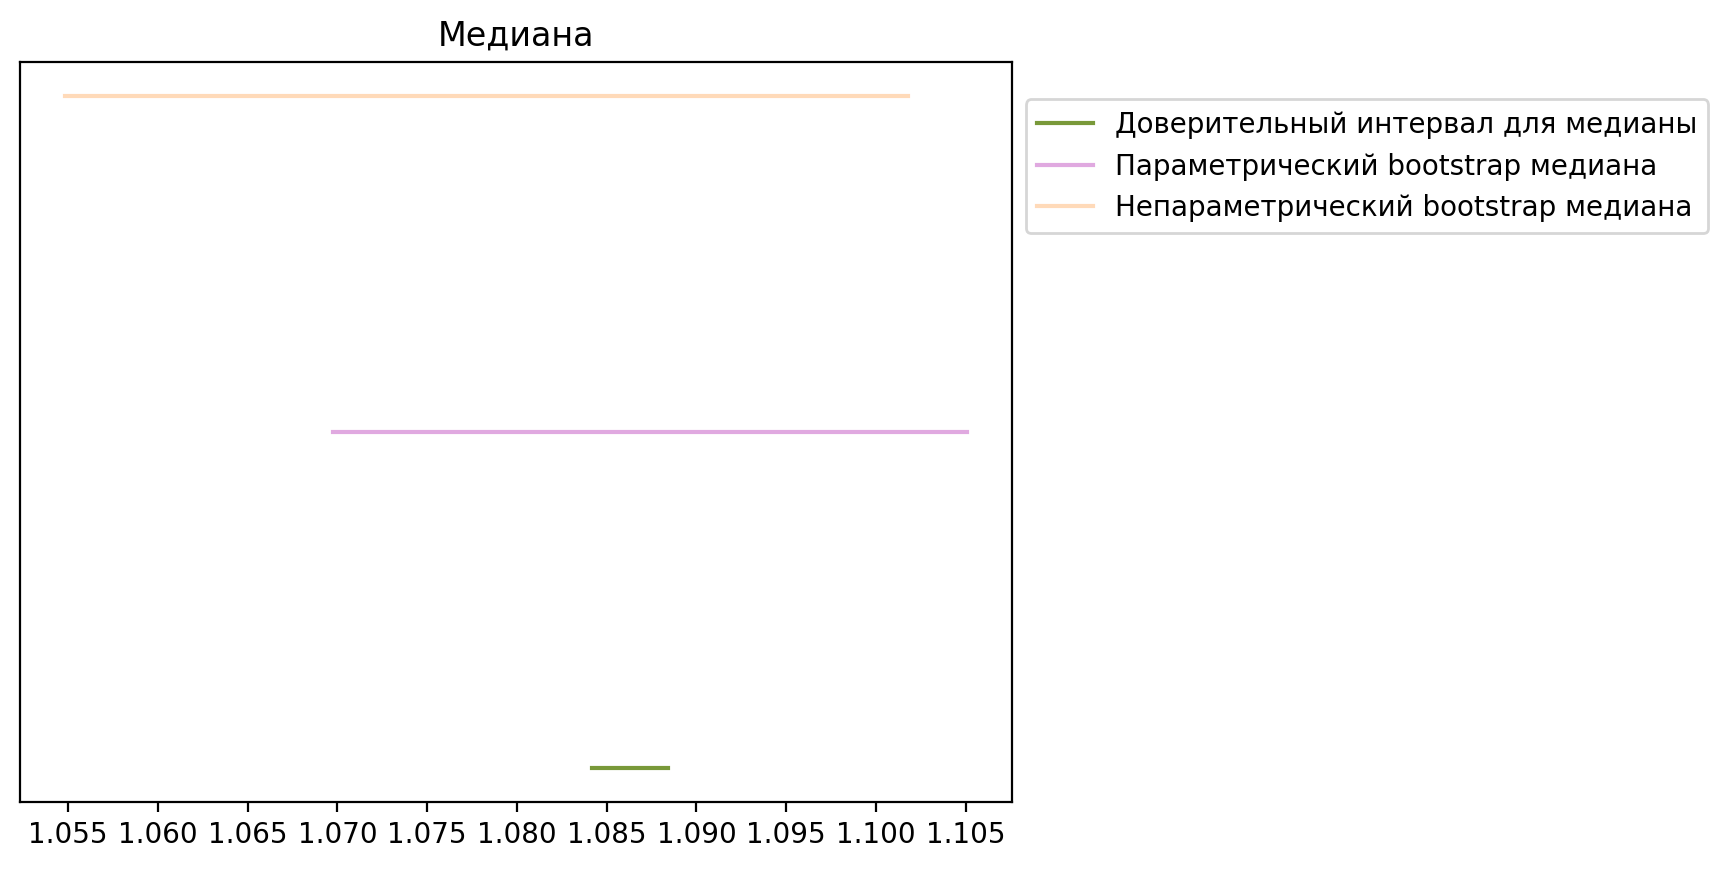

In [15]:
fig4, ax4 = plt.subplots(dpi=200)

ax4.plot([h1, h2], [1, 1], color='olivedrab', label='Доверительный интервал для медианы', alpha=0.9)
ax4.plot([parametric_h1_median, parametric_h2_median], [1.2, 1.2], color='plum',  label='Параметрический bootstrap медиана', alpha=0.9)
ax4.plot([nonparam_h1_median, nonparam_h2_median], [1.4, 1.4], color='peachpuff', label='Непараметрический bootstrap медиана')

ax4.set_yticks([])
ax4.xaxis.set_major_locator(ticker.MultipleLocator(0.005))

ax4.set_title("Медиана")
ax4.legend(loc='lower left', bbox_to_anchor=(1, 0.75))

plt.show()